# Hands-on 03: Tabular data and NNs: Classifying particle jets

In [27]:
! pip install tensorflow

In [28]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import os

import numpy as np
import tensorflow as tf

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Fetch the jet tagging dataset from Open ML

In [29]:
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)
X_file = os.path.join(data_dir, "X_jets.pkl")
y_file = os.path.join(data_dir, "y_jets.pkl")

if os.path.exists(X_file) and os.path.exists(y_file):
    print("Loading data from cached binary files...")
    X = pd.read_pickle(X_file)
    y = pd.read_pickle(y_file)
else:
    print("Fetching data from OpenML...")
    data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
    X, y = data["data"], data["target"]
    # Save as binary pickle for future use
    print("Saving data to binary files...")
    X.to_pickle(X_file)
    y.to_pickle(y_file)

Loading data from cached binary files...


### Let's print some information about the dataset
Print the feature names and the dataset shape

In [30]:
print(f"Feature names: {data['feature_names']}")
print(f"Target names: {y.dtype.categories.to_list()}")
print(f"Shapes: {X.shape}, {y.shape}")
print(f"Inputs: {X}")
print(f"Targets: {y}")

Feature names: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
Target names: ['g', 'q', 't', 'w', 'z']
Shapes: (830000, 16), (830000,)
Inputs:            zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.0400

As you see above, the `y` target is an array of strings, e.g. `["g", "w", ...]` etc.
These correspond to different source particles for the jets.
You will notice that except for quark- and gluon-initiated jets (`"g"`), all other jets in the dataset have at least one "prong."

<img src="images/jet_classes.png" alt="jet_classes" width="600"/>

### Lets see what the jet variables look like

Many of these variables are energy correlation functions $N$, $M$, $C$, and $D$ ([1305.0007](https://arxiv.org/pdf/1305.0007.pdf), [1609.07483](https://arxiv.org/pdf/1609.07483.pdf)). 
The others are the jet mass (computed with modified mass drop) $m_\textrm{mMDT}$, $\sum z\log z$ where the sum is over the particles in the jet and $z$ is the fraction of jet momentum carried by a given particle, and the overall multiplicity of particles in the jet.

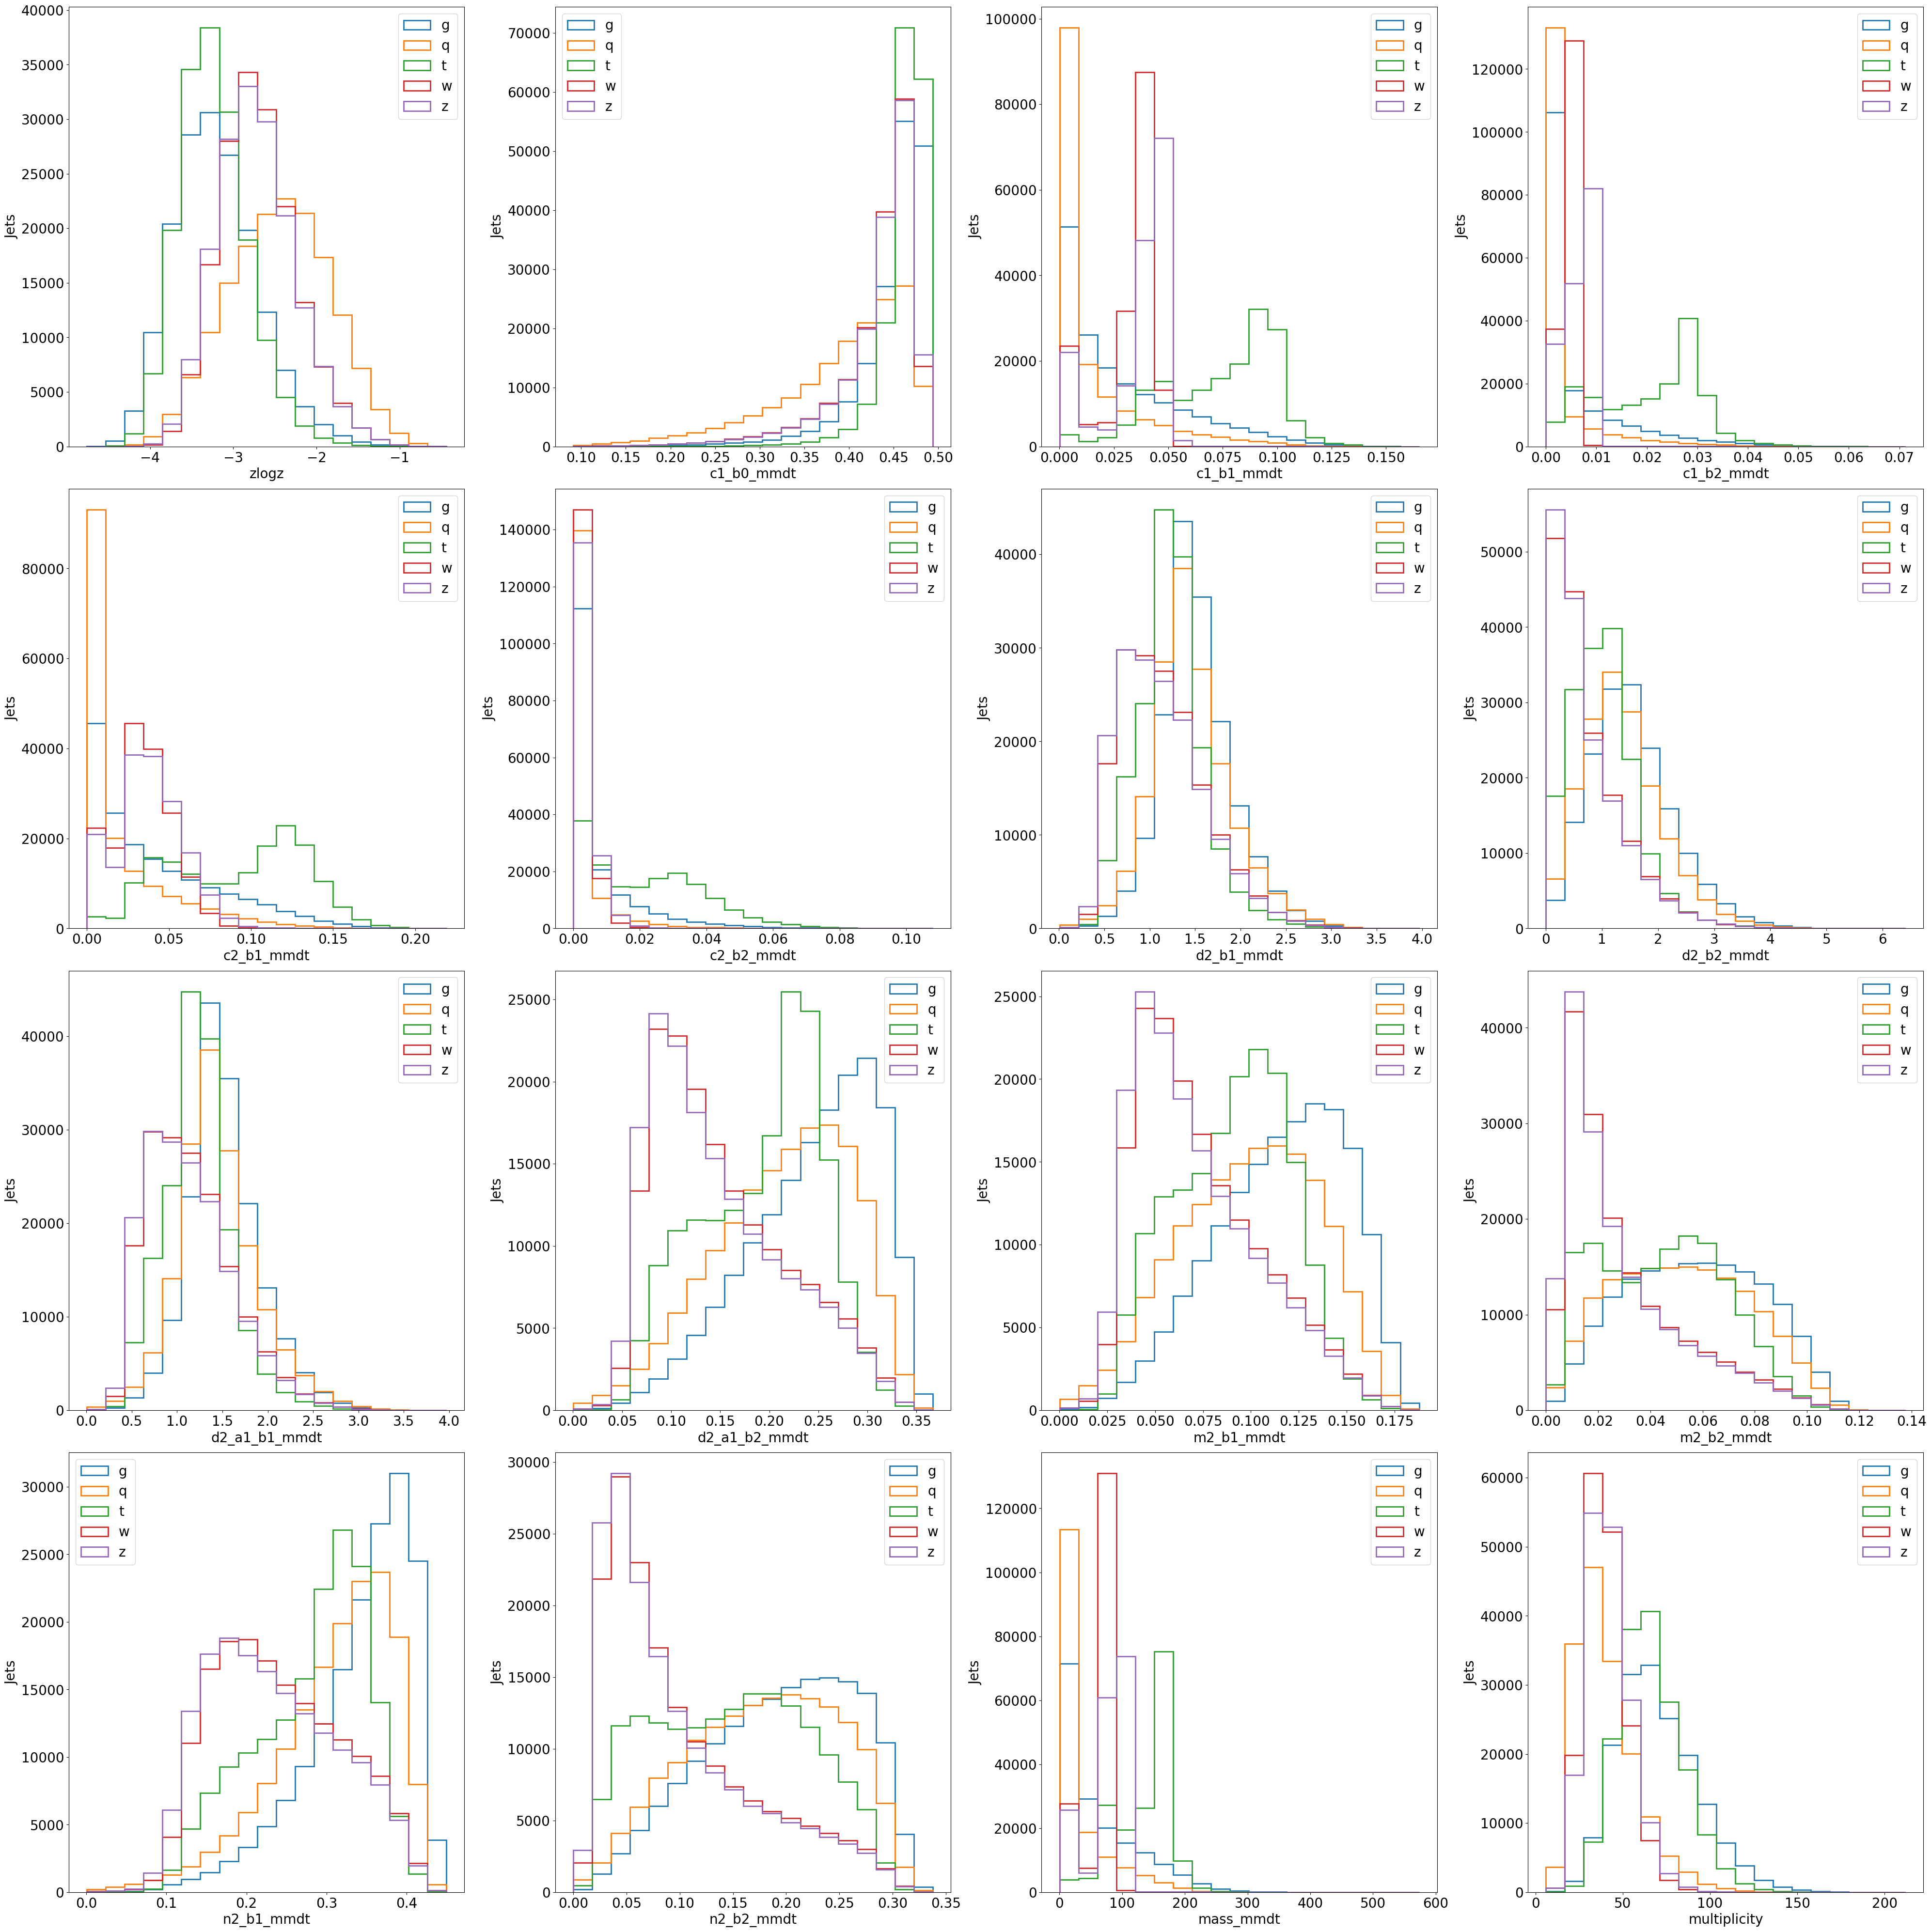

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(40, 40))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 20)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
plt.tight_layout()
plt.show()

Because the `y` target is an array of strings, e.g. `["g", "w", ...]`, we need to make this a "one-hot" encoding for the training.
Then, split the dataset into training and validation sets

In [32]:
le = LabelEncoder()
y_onehot = le.fit_transform(y)
y_onehot = to_categorical(y_onehot, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(y[:5])
print(y_onehot[:5])

0    g
1    w
2    t
3    z
4    w
Name: class, dtype: category
Categories (5, str): ['g', 'q', 't', 'w', 'z']
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


## Now construct a simple neural network
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [34]:
model = Sequential(name="sequential1")
model.add(Input(shape=(16,)))
model.add(Dense(64, name="fc1"))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()

Model: "sequential1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model
We'll use SGD optimizer with categorical crossentropy loss.
The model isn't very complex, so this should just take a few minutes even on the CPU.

In [35]:
model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

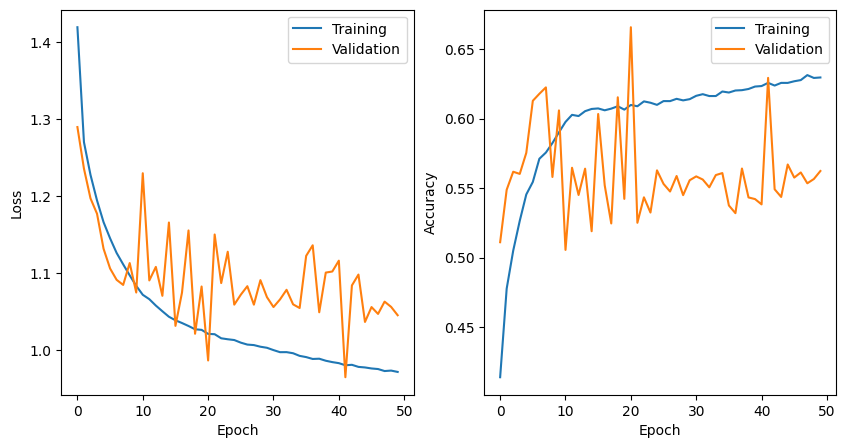

In [36]:
from plotting import plot_model_history

plot_model_history(history)

## Check performance
Check the accuracy and make a ROC curve

In [37]:
from plotting import make_roc, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.5623855421686746


<Figure size 500x500 with 0 Axes>

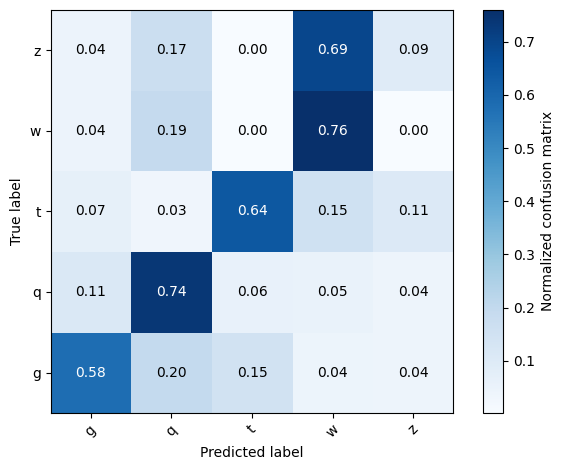

In [38]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

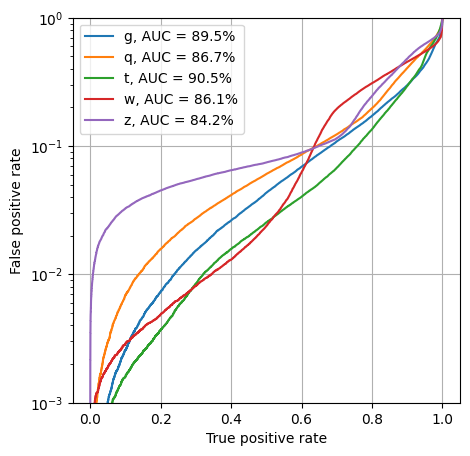

In [39]:
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

## Exercises

1. Apply a standard scaler to the inputs. How does the performance of the model change?

```python
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)
```

2. Apply L1 regularization. How does the performance of the model change? How do the distribution of the weight values change?

```python
model.add(Dense(64, input_shape=(16,), name="fc1", kernel_regularizer=l1(0.01)))
```

3. How do the loss curves change if we use a smaller learning rate (say `1e-5`) or a larger one (say `0.1`)?

4. How does the loss curve change and the performance of the model change if we use Adam as the optimizer instead of SGD?

In [49]:
def run_model(name, 
              X_training_data, 
              y_training_data, 
              X_test_data, 
              y_test_data, 
              optimizer="sgd", 
              scaled=False, 
              regularization=False, 
              modelSummary=False):

    if scaled:
        scaler = StandardScaler()
        X_training_data = scaler.fit_transform(X_training_data)
        X_test_data = scaler.transform(X_test_data)

    model = Sequential(name=f"sequential1_{name}")
    model.add(Input(shape=(16,)))
    if regularization:
        model.add(Dense(64, name="fc1", kernel_regularizer=l1(0.01)))
    else:
        model.add(Dense(64, name="fc1"))
    model.add(Activation(activation="relu", name="relu1"))
    model.add(Dense(32, name="fc2"))
    model.add(Activation(activation="relu", name="relu2"))
    model.add(Dense(32, name="fc3"))
    model.add(Activation(activation="relu", name="relu3"))
    model.add(Dense(5, name="fc4"))
    model.add(Activation(activation="softmax", name="softmax"))

    if modelSummary:
        model.summary()

    model.compile(optimizer=optimizer, loss=["categorical_crossentropy"], metrics=["accuracy"])
    history = model.fit(X_training_data, y_training_data, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

    plot_model_history(history)

    y_keras = model.predict(X_test_data, batch_size=1024, verbose=0)
    print(f"Accuracy: {accuracy_score(np.argmax(y_test_data, axis=1), np.argmax(y_keras, axis=1))}")

    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(y_test_data, y_keras, classes=le.classes_, normalize=True)

    plt.figure(figsize=(5, 5))
    make_roc(y_test_data, y_keras, le.classes_)

    return model

Accuracy: 0.7484879518072289


<Sequential name=sequential1_scaled, built=True>

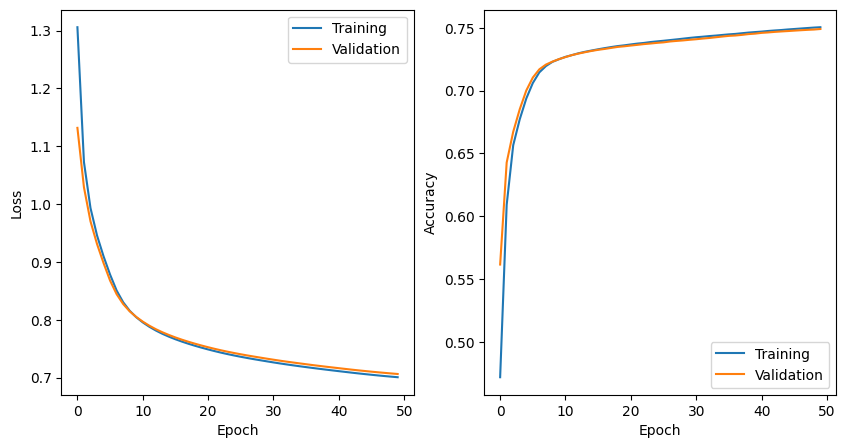

<Figure size 500x500 with 0 Axes>

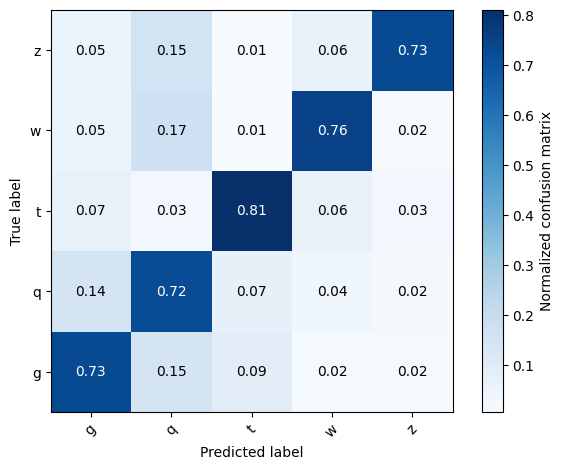

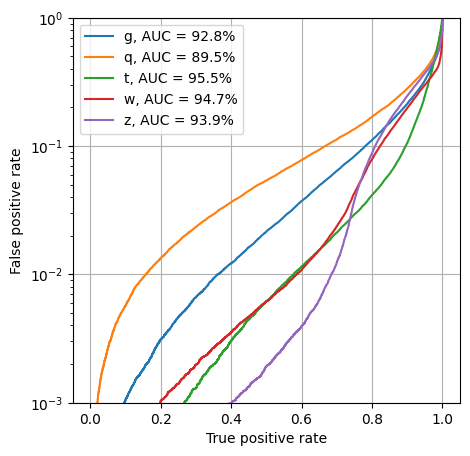

In [50]:
run_model("scaled", X_train_val, y_train_val, X_test, y_test, scaled=True)

Accuracy: 0.6037168674698795


<Sequential name=sequential1_L1, built=True>

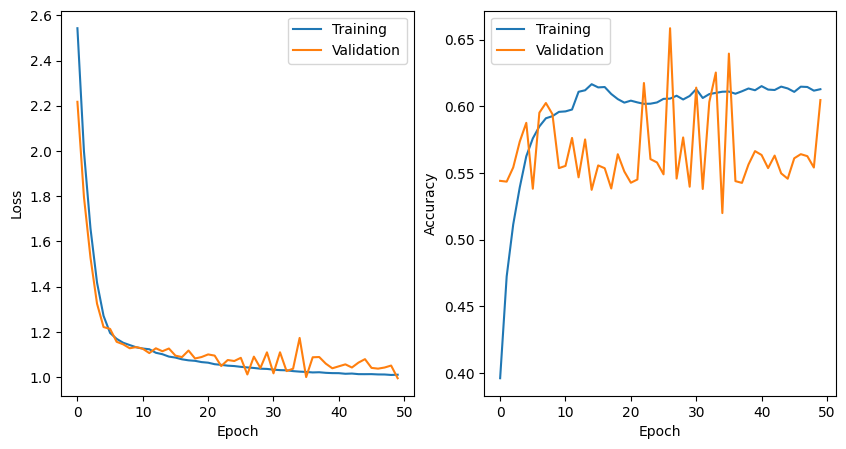

<Figure size 500x500 with 0 Axes>

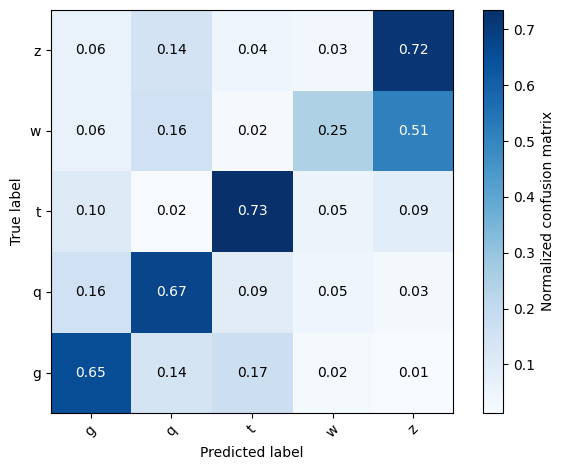

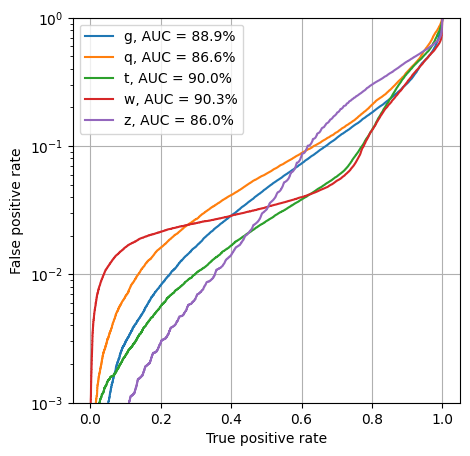

In [51]:
run_model("L1", X_train_val, y_train_val, X_test, y_test, regularization=True)

Training with learning rate: 1e-05
Accuracy: 0.4075361445783133
fc1 False False 0.28228724 -0.27313986
fc2 False False 0.25439736 -0.25250643
fc3 False False 0.3061699 -0.307825
fc4 False False 0.40049005 -0.39652243
Training with learning rate: 0.001
Accuracy: 0.6303734939759036
fc1 False False 0.6777125 -0.7609762
fc2 False False 0.32849246 -0.3613965
fc3 False False 0.4197935 -0.32631937
fc4 False False 0.4797756 -0.47463185
Training with learning rate: 0.1
Accuracy: 0.2016566265060241
fc1 False False 1.3541708e+09 -2.4423164e+10
fc2 False False 1.585921e+07 -1.5330986e+11
fc3 False False 133856.53 -3.64367e+07
fc4 False False 1.373087e+08 -3.179713e+08


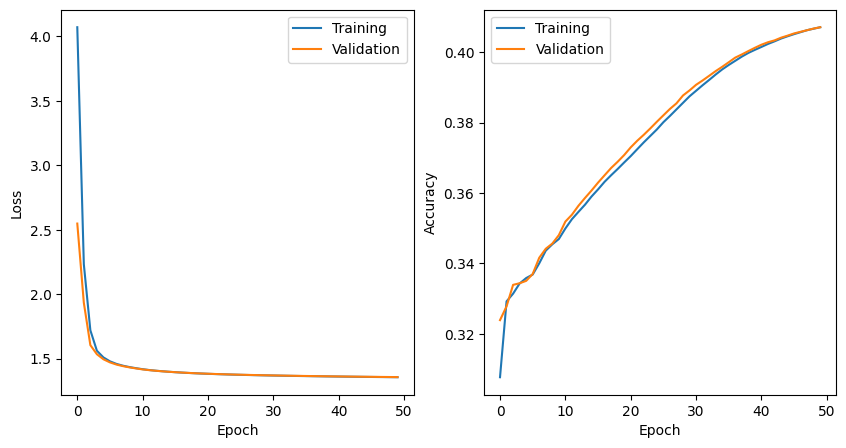

<Figure size 500x500 with 0 Axes>

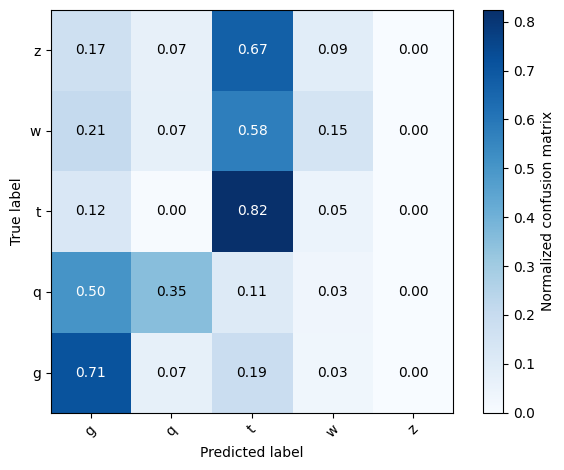

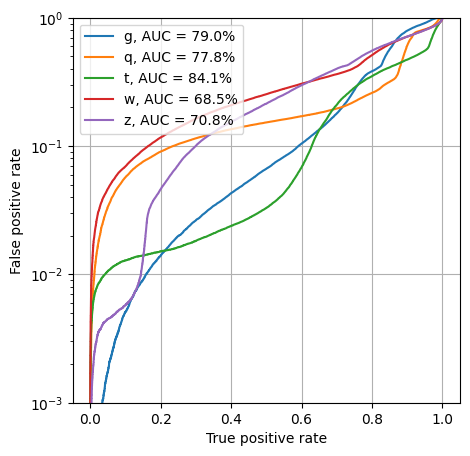

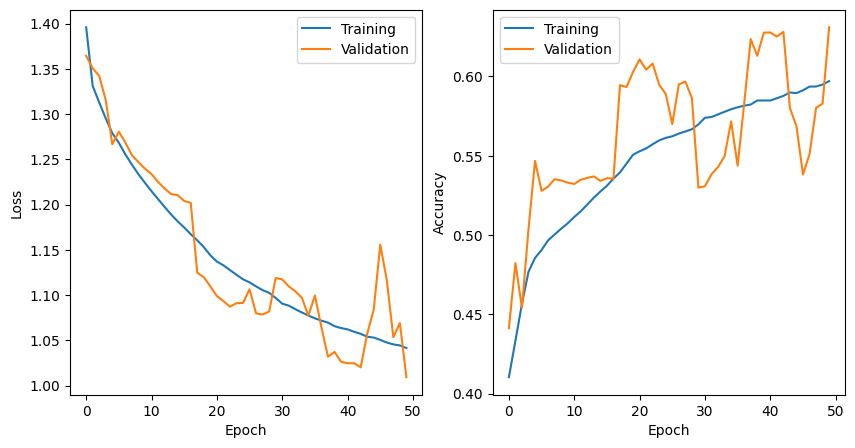

<Figure size 500x500 with 0 Axes>

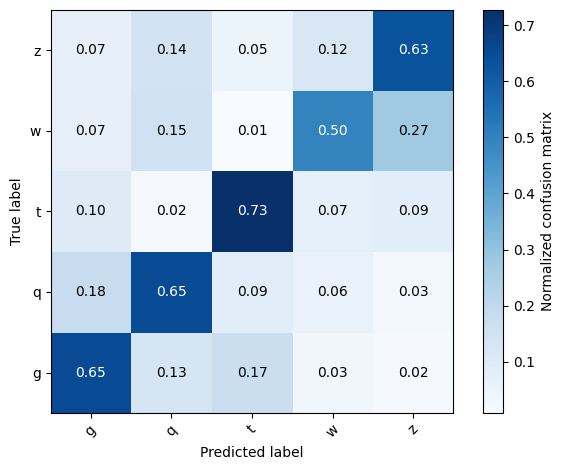

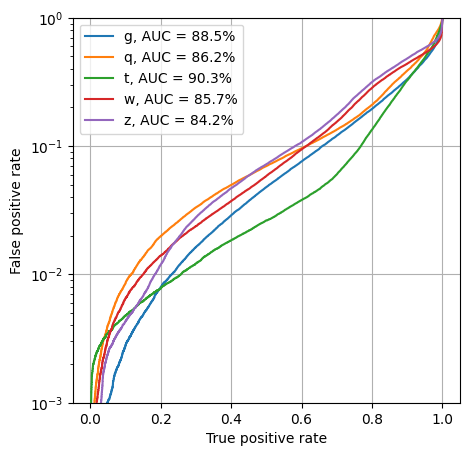

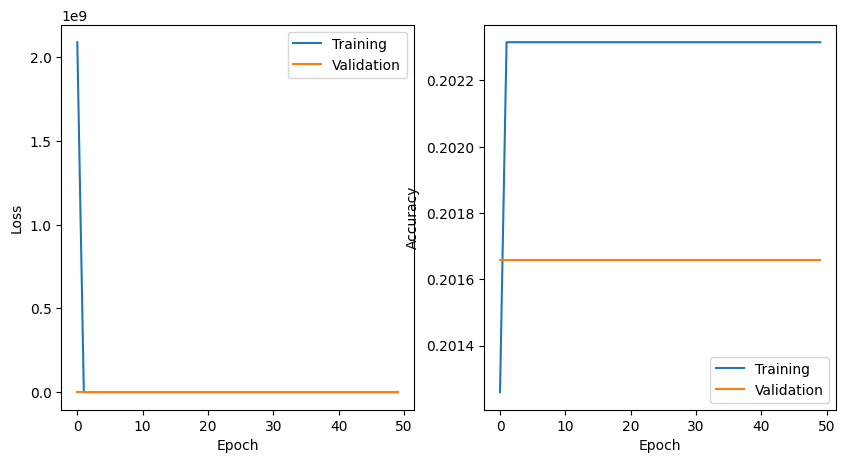

<Figure size 500x500 with 0 Axes>

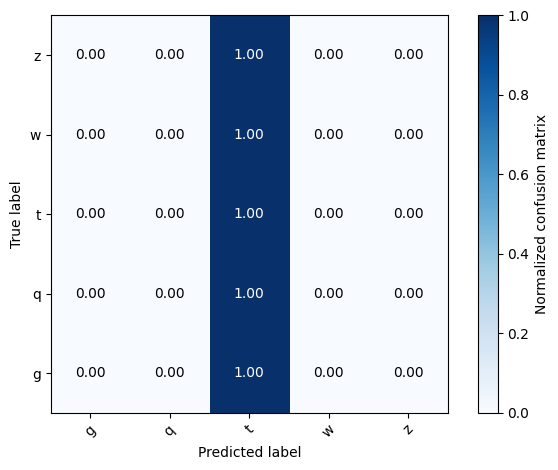

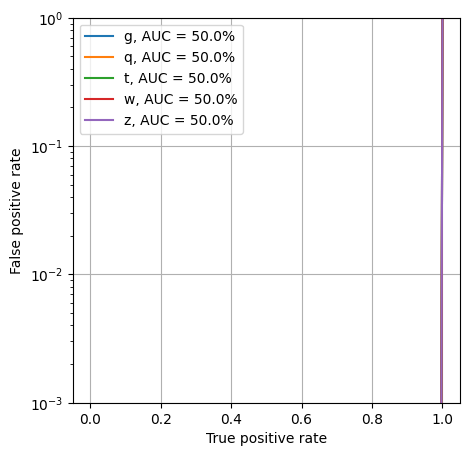

In [52]:
from tensorflow.keras.optimizers import SGD

learning_rates = [1e-5, 0.001, 0.1]

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = run_model(f"lr_{lr}", X_train_val, y_train_val, X_test, y_test, optimizer=SGD(learning_rate=lr))
    for layer in model.layers:
        w = layer.get_weights()
        if w:
            arr = w[0]
            print(layer.name, np.isnan(arr).any(), np.isinf(arr).any(), np.max(arr), np.min(arr))


Accuracy: 0.6176204819277108


<Sequential name=sequential1_sgd, built=True>

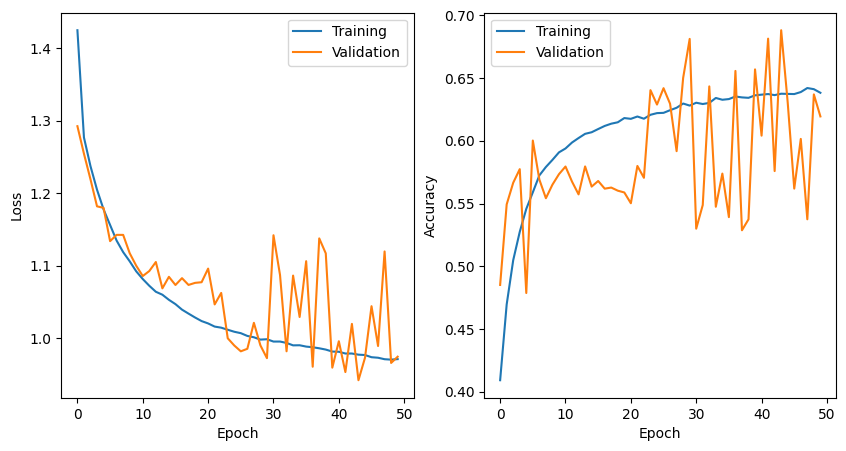

<Figure size 500x500 with 0 Axes>

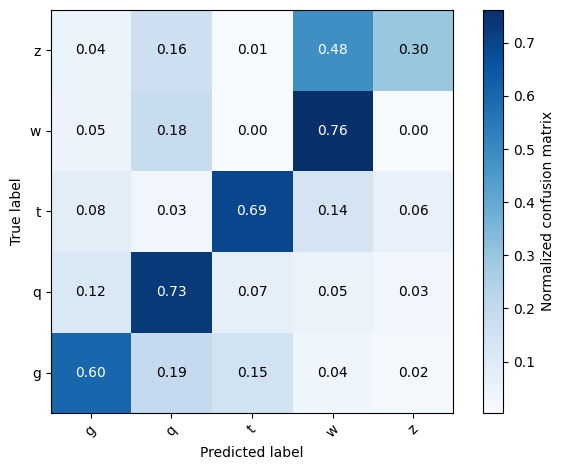

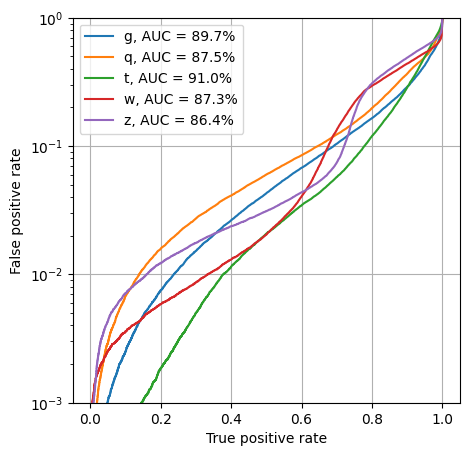

In [53]:
run_model(f"sgd", X_train_val, y_train_val, X_test, y_test)

Accuracy: 0.7369939759036145


<Sequential name=sequential1_adam, built=True>

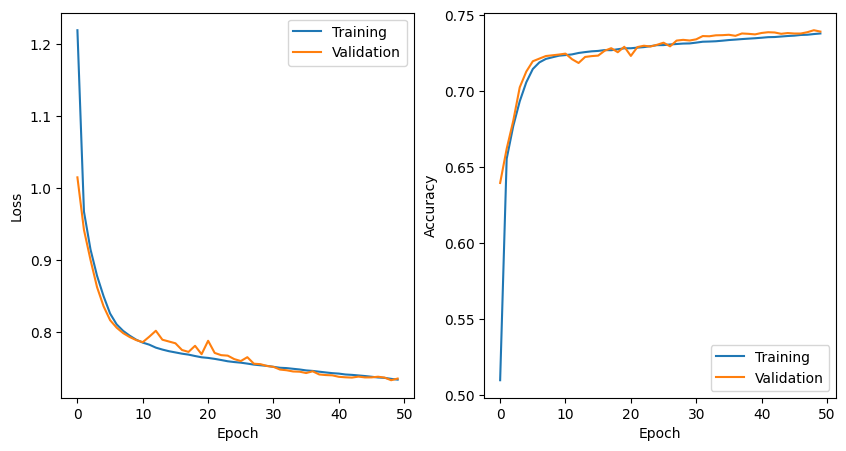

<Figure size 500x500 with 0 Axes>

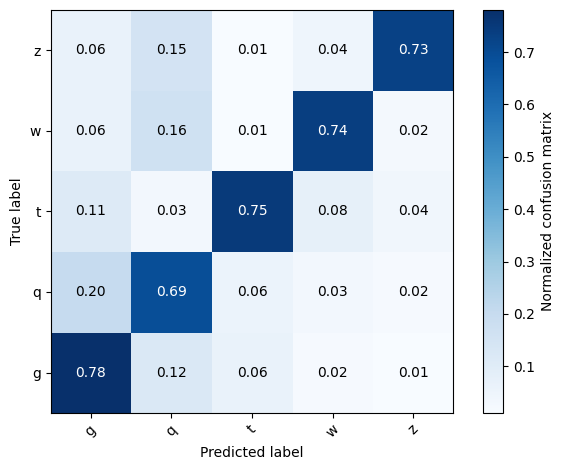

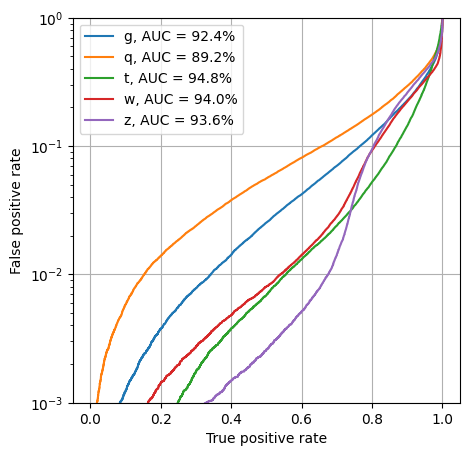

In [54]:
run_model(f"adam", X_train_val, y_train_val, X_test, y_test, optimizer="adam")